In [219]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import cv2
import fim_functions
from fim_functions import *
from skimage import io
from skimage.registration import phase_cross_correlation
from time import time

# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the GPU device
    device = torch.device("cuda:1")
    # device = torch.device("cpu")
    print("a")
    force_full_rank = True  # torch.linalg.lstsq requires full rank input

#elif torch.backends.mps.is_available() &&:
#    mps_device =torch.device("mps")
#    x=torch.ones(1,device=mps_device)
#    device = mps_device
#    print(x)

else:
    device = torch.device("cpu")
    force_full_rank = False
    print("v")

v


In [220]:
NA = 0.5  # numerical aperture -- defines angle of the cone of light collection of objective
RI_water = 1.33  # refractive index of water
half_theta = torch.arcsin(torch.tensor(NA/RI_water))  # half angle of cone
RI_sphere = 1.458#1.458  # refractive index of sphere (finding a sphere with low RefractiveIndex is better!)
dxy = 0.4935 #1.39*4#5.55#0.624  # lateral pixel size in um
dz = 3.#3.0 #1.39*4#5.55#1.  # axial step size in um

n_rays = 10#81  # number of rays in bundle to propagate within cone along one spatial dimension (i.e., up to n_rays x n_rays rays will be propagated)

#  광선 수 줄여서 속도 향상 시킬 수 있다. 4*4 여기 숫자 쓰면 곱셈이양 
downsamp_xy = 8  # downsample factors for the raw image stacks 
downsamp_z = 4
# 1. 코드 상단에 정의된 변수들을 사용해 종횡비를 계산합니다.

# downsamp 변수들은 다운샘플링을 하지 않았다면 1로 가정합니다.
#aspect_ratio = ( downsamp_z) / ( downsamp_xy)
#aspect_ratio = (dz * downsamp_z) / (dxy * downsamp_xy) - gave wrong image size 

#sig_proj = .42465  # for interpolation, keep fixed
d_to_focus = 3000  # distance in um ray has to travel to reach the focus in air
r_to_oblique = d_to_focus*torch.tan(half_theta)  # at d_to_focus distance away from focus, what radial distance of most oblique ray
r_sphere = 500  # radius of sphere in um
model_ellipsoid = False  # as opposed to perfect sphere
if model_ellipsoid:
    sphere_parameter = torch.eye(3)/r_sphere**2
else:
    sphere_parameter = r_sphere


In [221]:
# load data// /Users/noahahn/Desktop/lab_umich_Pro_Zhou/projects/Epoxy_0.45xZoom_precisionSphere
#file_with_sphere = '/home/kevin/Downloads/epoxy_0.45xZoom_withSphere_1.01mm.tif'
#file_without_sphere = '/home/kevin/Downloads/epoxy_0.45xZoom_withoutSphere_1.01mm.tif'

file_with_sphere = "./data_for_indentation/Edmund_Sphere_5_indent_stack.tif"
file_without_sphere = "./data_for_indentation/Edmund_Sphere_5_after_indent_stack.tif"

stack_with_sphere_np = io.imread(file_with_sphere)[::downsamp_z, ::downsamp_xy, ::downsamp_xy].transpose(1,2,0)  # move z to last dim
stack_without_sphere_np = io.imread(file_without_sphere)[::downsamp_z, ::downsamp_xy, ::downsamp_xy].transpose(1,2,0)
print(stack_with_sphere_np.shape)


(360, 360, 59)


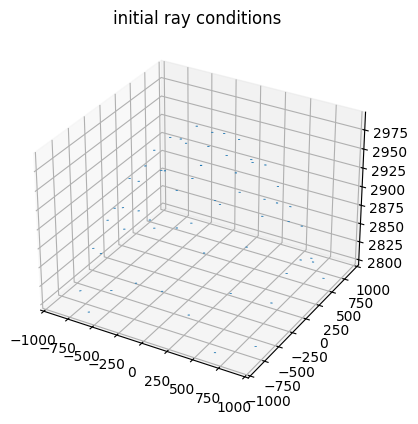

In [222]:
# create ray bundle:
x_ = torch.linspace(-r_to_oblique, r_to_oblique, n_rays)  # for meshgrid, x
# y_ = torch.tensor([0.]) # set to a single element if you just want to visualize in 1D
y_ = torch.linspace(-r_to_oblique, r_to_oblique, n_rays)
z_ = torch.tensor(d_to_focus, dtype=torch.float32)
x, y, z = torch.meshgrid(x_, y_, z_)
x = x.flatten()
y = y.flatten()
z = z.flatten()
r_rays = torch.stack([x, y, z], axis=1)
r_rays = r_rays[torch.linalg.norm(r_rays[:, 0:2], axis=1) <= r_to_oblique]  # turn pyramid to cone of rays
u_rays = -r_rays
u_rays = u_rays / torch.linalg.norm(u_rays, axis=1, keepdims=True)
r_rays = -u_rays*d_to_focus  # this makes it so all rays start on a sphere
# the rays converge to the origin
# sphere is always at the origin, by my definition

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(r_rays[:,0],r_rays[:,1],r_rays[:,2],u_rays[:,0],u_rays[:,1],u_rays[:,2])
plt.title('initial ray conditions')
plt.show()


In [223]:
delta_r = torch.tensor([0, 0, -1500])  # pick a random position for the focus
#delta_r = torch.tensor([400, 0, -600])  # pick a random position for the focus
# delta_r = torch.tensor([0, 0, -800])  # pick a random position for the focus
# delta_r = torch.tensor([0, 0, -1500])  # pick a random position for the focus

(r0, u0, r_at_sphere1, r_at_sphere2, 
 u_at_sphere1, u_at_sphere2, 
 r_trajectory_sphere, discriminant1, 
 discriminant2, r_focus, hit_sphere2, SSR) = propagate_static_shapes(delta_r, r_rays, u_rays, sphere_parameter, d_to_focus,
                                                                     RI_sphere=RI_sphere, RI_water=RI_water, force_full_rank=True,
                                                                     model_ellipsoid=model_ellipsoid
                                                                    )
# these have to be created outside of the propagate_static_shapes function because the shapes are not static:
r_trajectory_sphere = r_trajectory_sphere[torch.logical_and(discriminant1>0, discriminant1>0)]
r0_miss = r0[discriminant1<=0]
r_trajectory_no_sphere = torch.stack([r0_miss, torch.zeros_like(r0_miss) + delta_r], axis=-1)


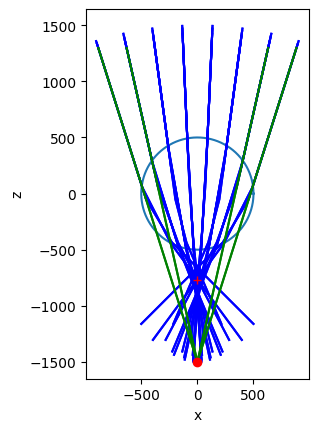

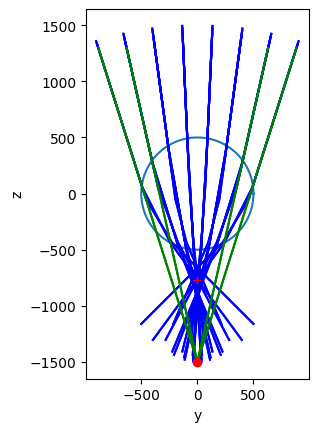

In [224]:
# plot an example ray trace through a sphere

def plot_trajectories_2D(r_trajectory_sphere, r_trajectory_no_sphere, axis=0, xlim=None, zlim=None):
  # axis can be 0 or 1 -- picks which of the two lateral dimensions
  theta = np.linspace(0, 2*np.pi, 200)
  x = r_sphere * np.cos(theta)
  z = r_sphere * np.sin(theta)
  plt.plot(x, z)

  if r_trajectory_sphere is not None:
    for ray in r_trajectory_sphere:
      plt.plot(ray[axis], ray[2], 'b')
    plt.plot(r_focus[axis], r_focus[2], 'r+')  # "best" focus
  for ray in r_trajectory_no_sphere:
    plt.plot(ray[axis], ray[2], 'g')
  plt.plot(delta_r[axis], delta_r[2], 'ro')  # where unaberrated focus would've been
  if xlim is not None:
    plt.xlim(xlim)
  if zlim is not None:
    plt.ylim(zlim)
  plt.gca().set_aspect('equal')
  plt.ylabel('z')
  if axis==0:
    plt.xlabel('x')
  elif axis==1:
    plt.xlabel('y')
  plt.show()

plot_trajectories_2D(r_trajectory_sphere, r_trajectory_no_sphere)
plot_trajectories_2D(r_trajectory_sphere, r_trajectory_no_sphere, axis=1)


[-6.96875 23.75   ]


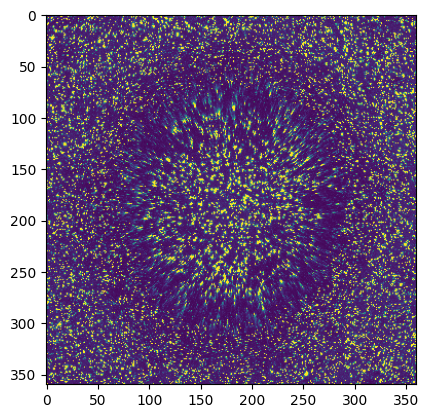

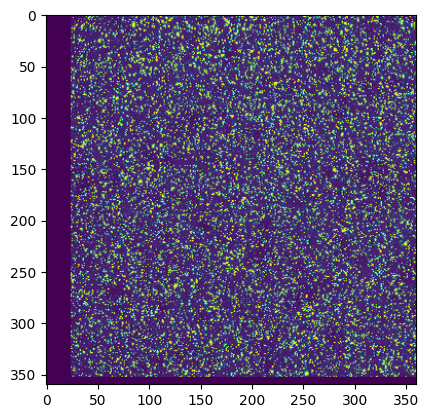

[-7.      -0.03125]


In [225]:
# use xcorr to get initial guess for xy shift:
max_with_sphere = stack_with_sphere_np.max(2)
max_without_sphere = stack_without_sphere_np.max(2)
xy_shift, _, _ = phase_cross_correlation(max_with_sphere, max_without_sphere, upsample_factor=32)
print(xy_shift)

# double check:
plt.imshow(max_with_sphere)
plt.show()
plt.imshow(scipy.ndimage.shift(max_without_sphere, xy_shift))
plt.show()

# now do z shift:
mean_with_sphere = stack_with_sphere_np.max(1)
mean_without_sphere = stack_without_sphere_np.max(1)
xz_shift, _, _ = phase_cross_correlation(mean_with_sphere, mean_without_sphere, upsample_factor=32)
print(xz_shift)
z_shift = xz_shift[1]


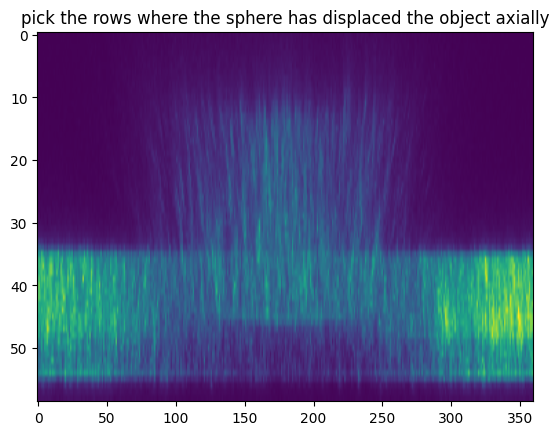

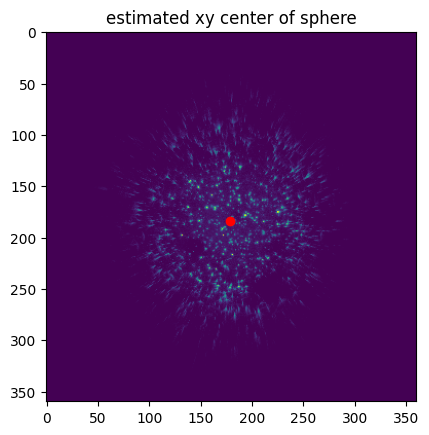

-1.0935430166522906 4.384661358846586


In [226]:
# get crude estimate of the center of the sphere in xy
# 2. 이미지를 표시할 때 계산된 종횡비를 'aspect' 인자로 전달합니다.
plt.imshow(stack_with_sphere_np.mean(0).T, aspect='auto')
plt.title('pick the rows where the sphere has displaced the object axially')

#plt.xlim(500, 2500) # Adjust these values as needed to zoom in or out

plt.show()
row = 32

# find center of mass of axially displaced region
displaced_region = stack_with_sphere_np[:,:,0:(row)].mean(2)
#displaced_region = stack_with_sphere_np[:,:,0:(row//downsamp_xy)].mean(2)
displaced_region = np.maximum(displaced_region-2, 0)  # remove some residual background that might influence the center of mass
xx = np.arange(0, displaced_region.shape[0])
yy = np.arange(0, displaced_region.shape[1])
xx, yy = np.meshgrid(xx, yy)
com_x = np.sum(xx*displaced_region) / np.sum(displaced_region)
com_y = np.sum(yy*displaced_region) / np.sum(displaced_region)
plt.imshow(displaced_region)
plt.plot(com_x, com_y, 'ro')
plt.title('estimated xy center of sphere')
plt.show()

dx_sphere = com_x-displaced_region.shape[0]//2
dy_sphere = com_y-displaced_region.shape[1]//2
print(dx_sphere, dy_sphere)  # displacement in pixels


하단 표면 위치 (픽셀): 35
상단 표면 위치 (픽셀): 55
측정된 두께 (픽셀): 20

최종 측정된 Epoxy의 두께는 약 240.00 µm 입니다.


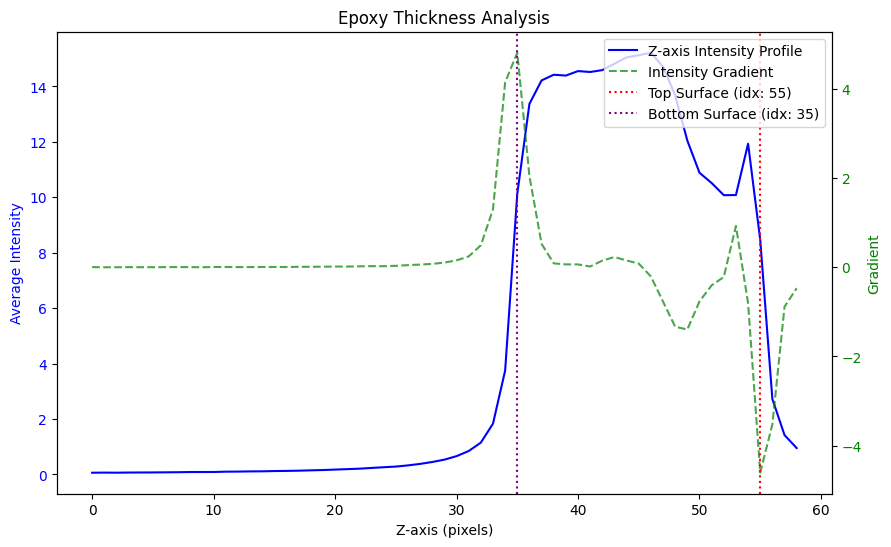

r IS... 500 306.0
Z_OFFSET IS... 806.0


In [227]:
import numpy as np
import matplotlib.pyplot as plt
# skimage.io는 이미지를 불러올 때 필요합니다.
# from skimage import io

def measure_epoxy_thickness(image_stack_3d, dz_microns,downsamp_z):
    """
    3D 이미지 스택에서 Epoxy 층의 두께를 측정합니다.

    Args:
        image_stack_3d (np.ndarray): (Y, X, Z) 축 순서의 3D 이미지 데이터.
        dz_microns (float): Z축 픽셀 한 개의 실제 크기 (마이크론 단위).

    Returns:
        float: 측정된 Epoxy의 두께 (마이크론 단위).
    """
    # 1. Z축 밝기 프로파일 계산
    # 3D 스택의 각 Z 슬라이스에 대해 XY 평면의 평균 밝기를 계산합니다.
    # 이를 통해 전체 스택의 Z축 방향 밝기 분포(1D 배열)를 얻습니다.
    # axis=(0, 1)은 Y축과 X축을 의미합니다.
    z_intensity_profile = np.mean(image_stack_3d, axis=(0, 1))

    gradient = np.gradient(z_intensity_profile)

    bottom_surface_index = np.argmax(gradient)

    top_surface_index = np.argmin(gradient)
    
    thickness_in_pixels = abs(top_surface_index - bottom_surface_index)

    # 픽셀 단위 두께를 실제 물리적 두께(마이크론)로 변환합니다.
    thickness_in_microns = thickness_in_pixels * dz_microns *downsamp_z

    print(f"하단 표면 위치 (픽셀): {bottom_surface_index}")
    print(f"상단 표면 위치 (픽셀): {top_surface_index}")
    print(f"측정된 두께 (픽셀): {thickness_in_pixels}")
    
    # 시각화를 위해 계산 결과 반환
    return thickness_in_microns, z_intensity_profile, gradient, top_surface_index, bottom_surface_index

# --- 실행 및 시각화 예시 ---

# 이전에 불러온 '구가 없는' 이미지 데이터를 사용합니다.
# stack_without_sphere_np = io.imread('your_file.tif').transpose(1, 2, 0)
# dz = 5.55 # Z축 픽셀 사이즈 (마이크론)

# # (실행을 위한 가상 데이터 생성)
# # 실제 데이터가 있다면 이 부분을 주석 처리하고 위 코드를 사용하세요.# # (가상 데이터 생성 끝)

# 함수를 호출하여 두께를 계산합니다.
thickness, profile, grad, top_idx, bottom_idx = measure_epoxy_thickness(stack_without_sphere_np, dz,downsamp_z)

print(f"\n최종 측정된 Epoxy의 두께는 약 {thickness:.2f} µm 입니다.")

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(profile, color='blue', label='Z-axis Intensity Profile')
ax1.set_xlabel('Z-axis (pixels)')
ax1.set_ylabel('Average Intensity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(grad, color='green', linestyle='--', alpha=0.7, label='Intensity Gradient')
ax2.set_ylabel('Gradient', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 3. 탐지된 경계면을 수직선으로 표시
plt.axvline(x=top_idx, color='red', linestyle=':', label=f'Top Surface (idx: {top_idx})')
plt.axvline(x=bottom_idx, color='purple', linestyle=':', label=f'Bottom Surface (idx: {bottom_idx})')
plt.title('Epoxy Thickness Analysis')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()
####################################자동화 완성
center_to_epxy_end_pixel= top_idx-stack_with_sphere_np.shape[2]/2;
print("r IS...",r_sphere, center_to_epxy_end_pixel*downsamp_z*dz)
z_offset= center_to_epxy_end_pixel*downsamp_z*dz+r_sphere;
print("Z_OFFSET IS...",z_offset)

In [228]:
# question: what if the light focuses before exiting the sphere???
# note: due to the interpolation, it seems the optimal shift is 1 pixel in x, y, and z (because the target is always on the grid, but
# we have to interpolate on a 2x2 grid)


In [229]:
x_range = torch.arange(0, stack_with_sphere_np.shape[0]) * dxy * downsamp_xy
y_range = torch.arange(0, stack_with_sphere_np.shape[1]) * dxy * downsamp_xy
z_range = torch.arange(0, stack_with_sphere_np.shape[2]) * dz * downsamp_z
######
z_offset = 800 # in micron / recalculate according to pixel / later remove hard coded val
z_offset = center_to_epxy_end_pixel*downsamp_z*dz+r_sphere;
######
x_range -= x_range.mean()
y_range -= y_range.mean()
z_range -= (z_range.mean() + z_offset)
x, y, z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')  # 'ij' is correct; 'xy' causes weird shearing
x = x.flatten()
y = y.flatten()
z = z.flatten()
delta_r = torch.stack([x, y, z], axis=1)  # 
propagate_vmap = torch.vmap(propagate_static_shapes, in_dims=(0, None, None, None, None, None, None, None, None), randomness='different')

delta_r = delta_r.to(device)
r_rays = r_rays.to(device)
u_rays = u_rays.to(device)

# apply other deformations besides refraction:
# REMOVE THIS ONE 1.21875*dxy*downsamp_xy*2
# xyz_shift_sphere = torch.tensor([-dy_sphere*dxy*downsamp_xy-1.21875*dxy*downsamp_xy*2,
#                                  -dx_sphere*dxy*downsamp_xy-1.53125*dxy*downsamp_xy*2,
#                                  0*z_shift*dz*downsamp_z], dtype=torch.float32, requires_grad=True, device=device)

xyz_shift_sphere = torch.tensor([-dy_sphere*dxy*downsamp_xy,
                                 -dx_sphere*dxy*downsamp_xy,
                                 0*z_shift*dz*downsamp_z], dtype=torch.float32, requires_grad=True, device=device)
xyz_shift_global = torch.tensor([-xy_shift[0]*dxy*downsamp_xy,
                                 -xy_shift[1]*dxy*downsamp_xy,
                                 -z_shift*dz*downsamp_z], dtype=torch.float32, requires_grad=True, device=device)
axis = torch.tensor([0.,0,1], requires_grad=True, device=device)
angle = torch.tensor(0., requires_grad=True, device=device)
n_sphere = torch.tensor(RI_sphere, requires_grad=True, device=device)
uz_scale = torch.tensor(1., requires_grad=True, device=device)  # changes the NA of the beam by scaling the uz component of unit vectors
transition_slope = torch.tensor(4., requires_grad=True, device=device)  # adjusts amplitude of things imaged by beams split by sphere
blur_factor = torch.tensor(10., requires_grad=True, device=device)  # adjusts how much to attenuate by blurring
if model_ellipsoid:
    ellipsoid_L = torch.tensor(np.eye(3, dtype=np.float32)/r_sphere, requires_grad=True, device=device)
    # the A matrix will be ellipsoid @ ellipsoid.T
else:
    radius = torch.tensor(np.float32(r_sphere), requires_grad=True, device=device)

variables = dict()
variables['xyz_shift_sphere'] = xyz_shift_sphere
variables['xyz_shift_global'] = xyz_shift_global
variables['axis'] = axis
variables['angle'] = angle
variables['n_sphere'] = n_sphere
variables['uz_scale'] = uz_scale
variables['transition_slope'] = transition_slope
variables['blur_factor'] = blur_factor
if model_ellipsoid:
    variables['radius_or_A'] = ellipsoid_L
else:
    variables['radius_or_A'] = radius


In [230]:
def forward_model(rand_ind, stack_with_sphere, stack_without_sphere, split_rays=False, weighted_loss=True, bilinear_interp=True):
    # split_rays: if True, then treat each ray bundle as having either gone through the sphere or not, but not both.
    # the procedure: use propagate_vmap to deform a uniform grid of xyz coordinates (your scan points). Use these new xyz coordinates
    # to sample the without-sphere image to deform the "perfect" image into what the warped image should look like. Finally, compare
    # this artificially warped image to the 3D image that's actually warped (ie without deforming it computationally, because it's already
    # warped).
    # in practice, use rand_ind to warp a subset of pixels because GPU not big enough.
    # note that the two captured stacks don't need to be the same shape. The xyz coordinates you choose to operate with must match
    # that of the captured stack with the sphere in it. 
    # bilinear_interp: if not, then use gaussian weighted interp

    if model_ellipsoid:
        radius_or_A = ellipsoid_L @ ellipsoid_L.T
    else:
        radius_or_A = radius
    
    delta_r_batch = delta_r[rand_ind]

    # this makes it so that even when the radius changes, the sphere is still sitting on the same surface:
    # this decouples xyz_shift_sphere and radius during optimization
    xyz_shift_sphere_total = xyz_shift_sphere.clone() # change later, mech deform
    if model_ellipsoid:
        geometric_mean_radius = 1/torch.prod(torch.linalg.eigvals(radius_or_A)).real**(1/6)  # geometric mean of the axes, since easy to compute
        # changed here , since MPS(THIS PART IS NOT SUPPORTED BY APPLE SILICON)
        '''radius_or_A_cpu = radius_or_A.cpu()  # MPS → CPU CONVERT
        eigenvals = torch.linalg.eigvals(radius_or_A_cpu)
        geometric_mean_radius = 1/torch.prod(eigenvals).real**(1/6)
        geometric_mean_radius = geometric_mean_radius.to(radius_or_A.device)  # CPU → MPS CONVERT AGAIN'''
        xyz_shift_sphere_total[2] += r_sphere-geometric_mean_radius.detach()
    else:
        xyz_shift_sphere_total[2] += r_sphere-radius  # r_sphere is the initial guess

    # modify the NA:
    u_rays_ = u_rays.clone()
    u_rays_[:, 2] *= uz_scale
    u_rays_ = u_rays_ / torch.linalg.norm(u_rays_, axis=1, keepdims=True)
    r_rays_ = -u_rays_*d_to_focus  # this makes it so all rays start on a sphere
    
    # propagate:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####:#####i changed from force_full_rank to force_full_rank=True#################################
    (r0, u0, r_at_sphere1, r_at_sphere2, 
     u_at_sphere1, u_at_sphere2, 
     r_trajectory_sphere, discriminant1, 
     discriminant2, r_focus, hit_sphere2, MSR) = propagate_vmap(delta_r_batch + xyz_shift_sphere_total[None], r_rays_, u_rays_, radius_or_A, 
                                                                d_to_focus, n_sphere, RI_water, force_full_rank, model_ellipsoid)  # note: can't use keyword arguments
    r_focus = r_focus - xyz_shift_sphere_total[None] # this ensures that only the sphere was shifted!
    frac_in_sphere = torch.mean((discriminant1 > 0).float(), dim=1).detach()  # detach, because thresholding isn't differentiable; save compute?
    
    if split_rays:
        # pick either rays going throuh sphere or not; for now, accept sphere-shifted focus if more than half of rays go thru sphere.
        # this step must be outside of vmap, because shapes are not staticall known.
        
        new_foci = torch.where(frac_in_sphere[:, None] > 0.5, r_focus, delta_r_batch)
    else:
        # keep track of both the rays that go through the sphere and don't (even if none actually go through sphere -- they'll be weighted 0)
        new_foci = torch.cat([r_focus, delta_r_batch], dim=0)  # basically make list of points twice as long
    
    rotmat = axis_angle_rotmat(axis, angle)
    new_foci = new_foci @ rotmat + xyz_shift_global[None]
    
    # convert to pixel space:
    x_float = new_foci[:, 0]/(dxy*downsamp_xy) + stack_without_sphere.shape[0] / 2
    y_float = new_foci[:, 1]/(dxy*downsamp_xy) + stack_without_sphere.shape[1] / 2
    z_float = (new_foci[:, 2]+z_offset)/(dz*downsamp_z) + stack_without_sphere.shape[2] / 2
    
    x_float = torch.clamp(x_float, min=0, max=stack_without_sphere.shape[0]-2)
    y_float = torch.clamp(y_float, min=0, max=stack_without_sphere.shape[1]-2)
    z_float = torch.clamp(z_float, min=0, max=stack_without_sphere.shape[2]-2)
    
    # trilinear interp:
    x_floor = torch.floor(x_float)
    x_ceil = x_floor + 1
    z_floor = torch.floor(z_float)
    z_ceil = z_floor + 1
    y_floor = torch.floor(y_float)
    y_ceil = y_floor + 1
    
    fx = x_float - x_floor
    cx = x_ceil - x_float
    fz = z_float - z_floor
    cz = z_ceil - z_float
    fy = y_float - y_floor
    cy = y_ceil - y_float
    
    # cast into integers:
    x_floor = x_floor.type(torch.int32)
    x_ceil = x_ceil.type(torch.int32)
    z_floor = z_floor.type(torch.int32)
    z_ceil = z_ceil.type(torch.int32)
    y_floor = y_floor.type(torch.int32)
    y_ceil = y_ceil.type(torch.int32)

    if bilinear_interp:
        fx, fy, fz, cx, cy, cz = cx, cy, cz, fx, fy, fz
    else:        
        # gaussian-weighted factors (these are for interp_project and for the gathering stage after projection):
        fx = torch.exp(-fx ** 2 / 2. / sig_proj ** 2)
        fy = torch.exp(-fy ** 2 / 2. / sig_proj ** 2)
        fz = torch.exp(-fz ** 2 / 2. / sig_proj ** 2)
        cx = torch.exp(-cx ** 2 / 2. / sig_proj ** 2)
        cy = torch.exp(-cy ** 2 / 2. / sig_proj ** 2)
        cz = torch.exp(-cz ** 2 / 2. / sig_proj ** 2)
    
    
    # compute the interpolated backprojection:
    # it might be more efficient to use broadcasting for this:
    f1 = fx * fy * fz
    f2 = fx * cy * fz
    f3 = cx * fy * fz
    f4 = cx * cy * fz
    f5 = fx * fy * cz
    f6 = fx * cy * cz
    f7 = cx * fy * cz
    f8 = cx * cy * cz
    
    # gathering stage for computing the loss
    fff = stack_without_sphere[x_floor, y_floor, z_floor]
    fcf = stack_without_sphere[x_floor, y_ceil, z_floor]
    cff = stack_without_sphere[x_ceil, y_floor, z_floor]
    ccf = stack_without_sphere[x_ceil, y_ceil, z_floor]
    ffc = stack_without_sphere[x_floor, y_floor, z_ceil]
    fcc = stack_without_sphere[x_floor, y_ceil, z_ceil]
    cfc = stack_without_sphere[x_ceil, y_floor, z_ceil]
    ccc = stack_without_sphere[x_ceil, y_ceil, z_ceil]
    
    forward = (ccc * f8 +
               ccf * f4 +
               cff * f3 +
               cfc * f7 +
               fcc * f6 +
               fcf * f2 +
               fff * f1 +
               ffc * f5)

    if not bilinear_interp:
        # (the bilinear interp weights should already sum to 1)
        forward /= (f8 +
                    f4 +
                    f3 +
                    f7 +
                    f6 +
                    f2 +
                    f1 +
                    f5)

    if not split_rays:
        # do a weighted average of the point that went thru sphere and not, based on the fraction of rays that did(n't) pass thru sphere
        thru_sphere, not_thru_sphere = torch.chunk(forward, 2, dim=0)
        frac_in_sphere = torch.clamp((frac_in_sphere-.5)*transition_slope+.5, 0, 1)  # make s-shaped
        attenuation_from_blur = blur_factor/(torch.sqrt(MSR.detach()[:, 0])+blur_factor)
        forward = thru_sphere * frac_in_sphere * attenuation_from_blur + not_thru_sphere * (1 - frac_in_sphere)
    
    xyz_rand_ind = torch.unravel_index(rand_ind, stack_with_sphere.shape)
    error = stack_with_sphere[xyz_rand_ind[0], xyz_rand_ind[1], xyz_rand_ind[2]] - forward
    if weighted_loss:
        weights = (frac_in_sphere-.5)**2  # weight things more strongly if rays were not split significantly
        MSE = torch.sum(weights*error**2)/torch.sum(weights)
    else:
        MSE = torch.mean(error**2)

    return MSE, forward, frac_in_sphere

def inference_2D_plane(stack_with_sphere, stack_without_sphere, dim, slice_index, num_batches, split_rays=False):
    # dim: which dimension to slice
    # slice_index: which slice to visualize from dimension dim
    # divide the slice num_batch batches so we can fit in memory 

    x_ = np.arange(stack_with_sphere.shape[0])
    y_ = np.arange(stack_with_sphere.shape[1])
    z_ = np.arange(stack_with_sphere.shape[2])
    
    # replace the dim you're slicing:
    if dim == 2:
        z_ = slice_index
    elif dim == 1:
        y_ = slice_index
    elif dim == 0:
        x_ = slice_index
    else:
        raise Exception('invalid dim')
    
    # get indices for the slice plane:
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    xyz_inds = np.ravel_multi_index((x,y,z), stack_with_sphere.shape)
    
    # partition the indices:
    ind_splits = np.array_split(xyz_inds, num_batches)
    
    flat_slice = list()
    fracs = list()
    with torch.no_grad():
        for split in ind_splits:
            _, forward, frac_in_sphere = forward_model(torch.tensor(split, device='cpu'), 
                                                       stack_with_sphere, stack_without_sphere, split_rays=split_rays)
            flat_slice.append(forward.cpu())
            fracs.append(frac_in_sphere.cpu())
    flat_slice = np.concatenate(flat_slice)
    fracs = np.concatenate(fracs)
    
    if dim == 2:
        slice = flat_slice.reshape(stack_with_sphere.shape[0:2])
        frac = fracs.reshape(stack_with_sphere.shape[0:2])
    elif dim == 1:
        slice = flat_slice.reshape(stack_with_sphere.shape[0], stack_with_sphere.shape[2])
        frac = fracs.reshape(stack_with_sphere.shape[0], stack_with_sphere.shape[2])
    elif dim == 0:
        slice = flat_slice.reshape(stack_with_sphere.shape[1:])
        frac = fracs.reshape(stack_with_sphere.shape[1:])
    
    return slice, frac

sigma_with_sphere = .5
sigma_without_sphere = 0
learning_rates = dict()
learning_rates['xyz_shift_sphere'] = 1e-2
learning_rates['xyz_shift_global'] = 1e-2
learning_rates['axis'] = 1e-8
learning_rates['angle'] = 1e-8
learning_rates['radius_or_A'] = 3e-7*0#.5e-2*0
learning_rates['n_sphere'] = 1e-3*0
learning_rates['uz_scale'] = 1e-3/100
learning_rates['transition_slope'] = 1e-3
learning_rates['blur_factor'] = 1e-3

optimizers = {torch.optim.Adam([variables[var]], learning_rates[var]) for var in variables.keys()}
if sigma_with_sphere>0 or sigma_without_sphere>0:
    stack_with_sphere_ = scipy.ndimage.gaussian_filter(stack_with_sphere_np, [sigma_with_sphere, sigma_with_sphere, 0])
    stack_without_sphere_ = scipy.ndimage.gaussian_filter(stack_without_sphere_np, [sigma_without_sphere, sigma_without_sphere, 0])
else:
    stack_with_sphere_ = stack_with_sphere_np
    stack_without_sphere_ = stack_without_sphere_np
stack_with_sphere = torch.Tensor(stack_with_sphere_).to(device)
stack_without_sphere = torch.Tensor(stack_without_sphere_).to(device)

losses = list()
var_history = {key: list() for key in variables.keys()}


In [231]:
# manually set some of the parameters:
# ####
# variables['xyz_shift_sphere'].data[0] = 61.9006 + -10
# variables['xyz_shift_sphere'].data[1] = 117.7033 + -10
# variables['xyz_shift_sphere'].data[2] = 0 + 0 - 30

# variables['xyz_shift_global'].data = torch.tensor([-0.8403, -1.2036, -1.1202]).to(device)
# variables['axis'].data = torch.tensor([-0.0691,  0.3805,  0.0393]).to(device)
# variables['angle'].data = torch.tensor(-0.0014).to(device)

# # variables['radius_or_A'].data = torch.tensor(505.).to(device)


In [232]:
# optimize the parameters via gradient descent

# generate random coordinates to propagate:
batch_size = 500 # try here                   @@@@@@@@
threshold = 100 #10  # if you wish to only choose pixels whose intensites exceed this threshold
use_same_batch = False #True

if threshold is not None:
    stack = stack_with_sphere.cpu().detach().numpy()
    stack[:,:,130:] = 0
    good_indices = torch.tensor(np.nonzero(stack.flatten()>=threshold)[0])

for i in tqdm(range(20001)):
    if use_same_batch and i > 0:
        pass
    else:
        if threshold is None:
            rand_ind = torch.randint(np.prod(stack_with_sphere.shape), (batch_size,))
        else:
            rand_ind = torch.randint(len(good_indices), (batch_size,))
            rand_ind = good_indices[rand_ind]
    try:
        MSE, forward, _ = forward_model(rand_ind, stack_with_sphere, stack_without_sphere, weighted_loss=False)
    except torch._C._LinAlgError:
        print('_LinAlgError')
        # generate another random perturbation
        continue
        
    MSE.backward(retain_graph=True)
    for optimizer in optimizers:
        optimizer.step()
        optimizer.zero_grad()  # IMPORTANT!
    losses.append(MSE.cpu().detach().numpy())

    if i % 1 == 0:
        for key in var_history.keys():
            var_history[key].append(variables[key].cpu().detach().numpy())

    if i % 100 == 0:
        print(i, MSE.cpu().detach().numpy())
    
    if i % 1000 == 0 and i > 0:
        plt.plot(losses)
        plt.title('loss history')
        plt.show()

        for ii, key in enumerate(variables.keys()):
            plt.subplot(3,3,ii+1)
            if model_ellipsoid and key == 'radius_or_A':
                plt.plot([1/np.abs(np.diag(k)) for k in var_history[key]])  # will yield radius if a sphere
            else:
                plt.plot(var_history[key])
            plt.title(key)
        plt.show()


  0%|          | 0/20001 [00:00<?, ?it/s]

0 15268.466
100 13698.942
200 12848.571
300 12691.78
400 11915.633
500 12022.458


KeyboardInterrupt: 

In [ ]:
# axes of the ellipsoid:
L = variables['radius_or_A'].detach().cpu().numpy()
1/np.sqrt(np.linalg.eigvals(L@L.T))


In [215]:
# create whole volumetric prediction of the warped image
slices = list()
fracs = list()
for ii in tqdm(range(0,stack_with_sphere.shape[2])):
    slice, frac = inference_2D_plane(stack_with_sphere, stack_without_sphere, dim=2, slice_index=ii, num_batches=10, split_rays=True)
    slices.append(slice)
    fracs.append(frac)


  0%|          | 0/59 [00:00<?, ?it/s]

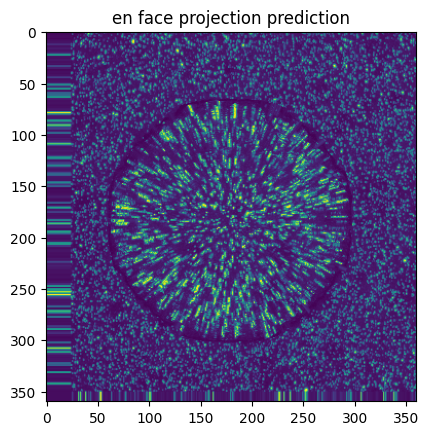

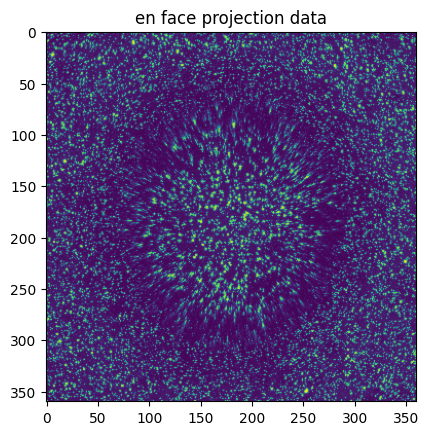

255.0


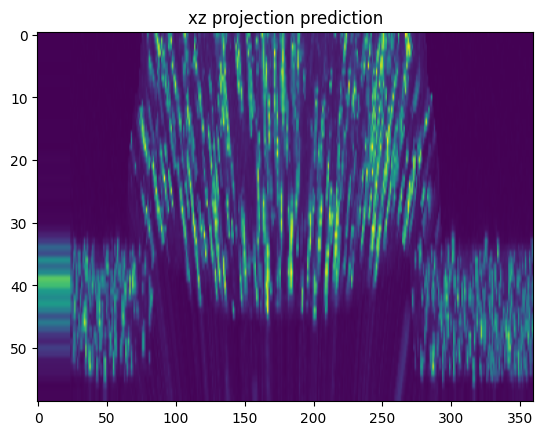

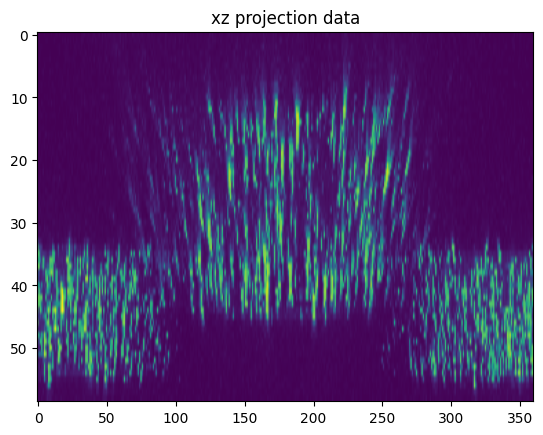

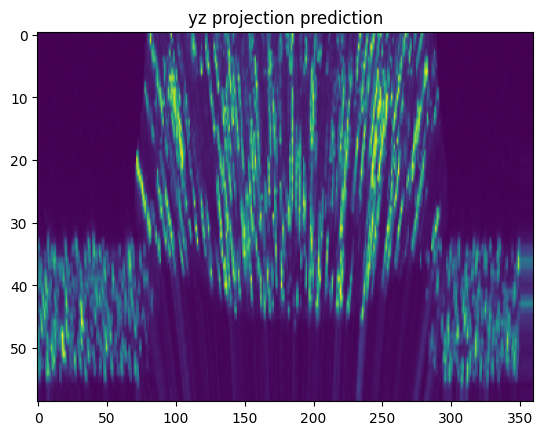

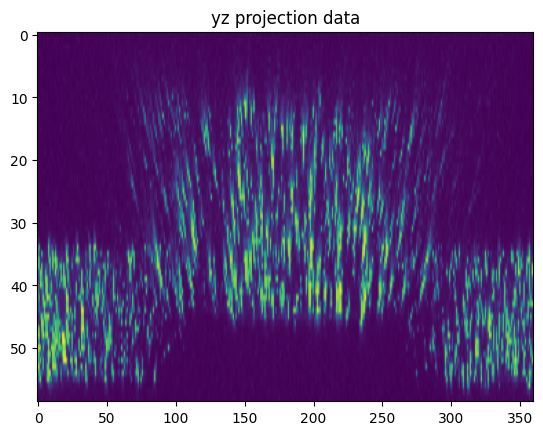

In [216]:
plt.imshow(np.max(slices, axis=0))

plt.title('en face projection prediction')
plt.show()
plt.imshow(stack_with_sphere.cpu().numpy().max(2))
plt.title('en face projection data')
plt.show()

# plt.imshow(np.max(slices, axis=1))
# plt.title('xz projection prediction')
# plt.show()
# plt.imshow(stack_with_sphere.cpu().numpy().max(1).T)
# plt.title('xz projection data')
# plt.show()

pred = np.array(slices)
window = 20
#plt.imshow(stack_with_sphere_np.max(0).T, aspect=aspect_ratio)
plt.imshow(np.max(pred[:, 128-window:128+window,:], axis=1), aspect='auto')

print(np.max(pred))
plt.title('xz projection prediction')
plt.show()
plt.imshow(stack_with_sphere.cpu().numpy()[128-window:128+window].max(0).T, aspect='auto')
plt.title('xz projection data')
plt.show()

pred = np.array(slices)
window = 20
plt.imshow(np.max(pred[:, :, 128-window:128+window], axis=2), aspect='auto')
plt.title('yz projection prediction')
plt.show()
plt.imshow(stack_with_sphere.cpu().numpy()[:, 128-window:128+window, :].max(1).T, aspect='auto')
plt.title('yz projection data')
plt.show()


In [ ]:
# compare 2D slices of the 3D reconstruction:

plt.show()


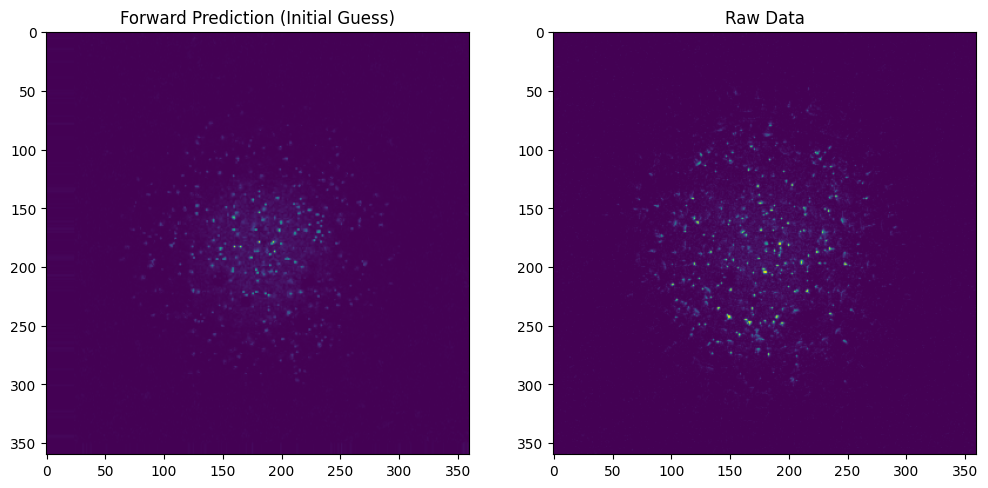

In [71]:
slice_index = stack_with_sphere.shape[2] // 2 

predicted_slice, _ = inference_2D_plane(
    stack_with_sphere, 
    stack_without_sphere, 
    dim=2, 
    slice_index=slice_index, 
    num_batches=5 # 테스트 시에는 더 작게 설정 가능
)

# 4. 예측과 실제 데이터를 나란히 놓고 비교합니다.
plt.figure(figsize=(12, 6))

# 예측된 슬라이스
plt.subplot(1, 2, 1)
plt.imshow(predicted_slice)
plt.title(f'Forward Prediction (Initial Guess)')

# 원본 데이터 슬라이스
plt.subplot(1, 2, 2)
original_slice = stack_with_sphere.cpu().numpy()[:, :, slice_index]
plt.imshow(original_slice)
plt.title(f'Raw Data')

plt.show()
